# Calibrating single-qubit gates on Armonk

In this tutorial we demonstrate how to calibrate single-qubit gates on Armonk using the Calibration framework in qiskit-experiments. We will run experiments to find the qubit frequency, calibrate the amplitude of DRAG pulses and chose the value of the DRAG parameter that minimizes leakage. The calibration framework requires the user to

* setup an instance of `Calibrations` or `BackendCalibrations`,
* run calibration experiments which can be found either in `qiskit_experiments.calibration` or `qiskit_experiments.characterization`, and
* update the values of the parameters stored in the instance of `Calibrations` (or `BackendCalibrations`) using `Update` classes. 

You will see that the `Update` classes are not meant to be instantiated but provide an `update` class method to extract calibrated parameter values and add them to the calibrations.

In [1]:
import numpy as np

import qiskit.pulse as pulse
from qiskit.circuit import Parameter

from qiskit_experiments.calibration.management.backend_calibrations import BackendCalibrations

from qiskit import IBMQ, schedule

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')

In [3]:
qubit = 0  # The qubit we will work with

In [4]:
def setup_cals(backend) -> BackendCalibrations:
    """A function to instantiate calibrations and add a couple of template schedules."""
    cals = BackendCalibrations(backend)

    dur = Parameter("dur")
    amp = Parameter("amp")
    sigma = Parameter("σ")
    beta = Parameter("β")
    drive = pulse.DriveChannel(Parameter("ch0"))

    # Define and add template schedules.
    with pulse.build(name="xp") as xp:
        pulse.play(pulse.Drag(dur, amp, sigma, beta), drive)

    with pulse.build(name="x90p") as x90p:
        pulse.play(pulse.Drag(dur, amp / 2.0, sigma, beta), drive)

    cals.add_schedule(xp)
    cals.add_schedule(x90p)
    
    return cals

def add_parameter_guesses(cals: BackendCalibrations):
    """Add guesses for the parameter values to the calibrations."""
    for sched in ["xp", "x90p"]:
        cals.add_parameter_value(80, "σ", schedule=sched)
        cals.add_parameter_value(0.5, "β", schedule=sched)
        cals.add_parameter_value(320, "dur", schedule=sched)
        cals.add_parameter_value(0.5, "amp", schedule=sched)

When setting up the calibrations we add two pulses: a $\pi$-rotation, with a schedule named `xp`, as well as a $\pi/2$-rotation, with a schedule named `x90p`. Here, we have linked the amplitude of both pulses, i.e. the amplitude of the $\pi/2$-rotation is half the amplitude of the $\pi$-rotation.

In [5]:
cals = setup_cals(backend)
add_parameter_guesses(cals)

## 1. Finding qubits with spectroscopy

Here, we are using a backend for which we already know the qubit frequency. We will therefore use the spectroscopy experiment to confirm that there is a resonance at the qubit frequency reported by the backend.

In [6]:
from qiskit_experiments.characterization.qubit_spectroscopy import QubitSpectroscopy

We first show the contents of the calibrations for qubit 0.

In [7]:
import pandas as pd

pd.DataFrame(cals.parameters_table(qubit_list=[qubit]))

,value,date_time,valid,exp_id,group,qubits,parameter,schedule
0,6.993371e+09,2021-07-16 13:11:30.810232+0000,True,None,default,"(0,)",meas_lo_freq,None
1,4.971662e+09,2021-07-16 13:11:30.810145+0000,True,None,default,"(0,)",qubit_lo_freq,None


In [8]:
freq01_estimate = backend.defaults().qubit_freq_est[qubit]
frequencies = np.linspace(freq01_estimate -15e6, freq01_estimate + 15e6, 51)
spec = QubitSpectroscopy(qubit, frequencies)
spec.set_experiment_options(amp=0.1)

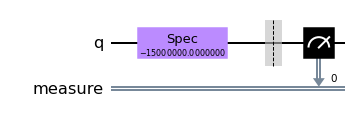

In [9]:
circuit = spec.circuits(backend)[0]
circuit.draw(output="mpl")

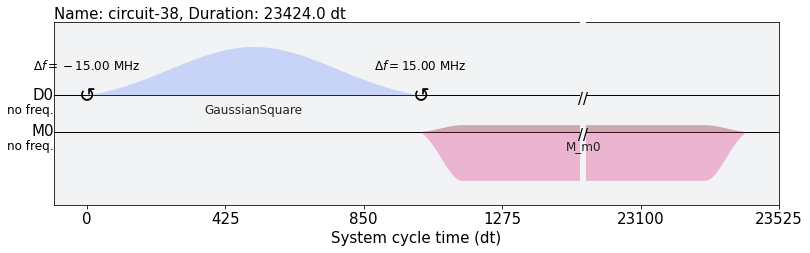

In [10]:
schedule(circuit, backend).draw()

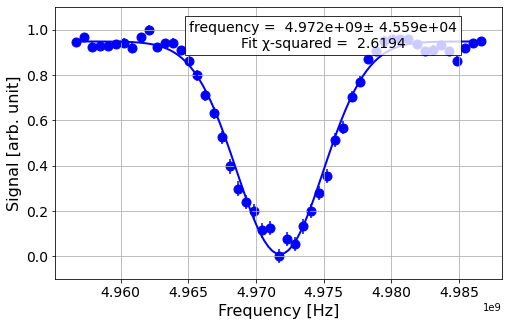

In [11]:
spec_data = spec.run(backend)

In [12]:
print(spec_data)

---------------------------------------------------
Experiment: QubitSpectroscopy
Experiment ID: bd1eabcd-c1c2-4094-b1dc-870c70eaed86
Status: DONE
Circuits: 51
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- a: -0.9392212291769281 ± 0.012588958638410143
- sigma: 3213486.893867788 ± 48144.73344982357
- freq: 4971772011.753467 ± 45593.620970167416
- b: 0.9477671953788612 ± 0.0041960962843386055
- analysis_type: ResonanceAnalysis
- reduced_chisq: 2.6193689026890516
- dof: 47
- xrange: [4956661834.669, 4986661834.669]
- quality: computer_good
- success: True


We now update the instance of `Calibrations` with the value of the frequency that we measured. Note that for the reminder of this notebook we use the value of the qubit frequency in the backend.

In [13]:
from qiskit_experiments.calibration.management.update_library import Frequency

Frequency.update(cals, spec_data)

In [14]:
pd.DataFrame(cals.parameters_table(qubit_list=[qubit]))

,value,date_time,valid,exp_id,group,qubits,parameter,schedule
0,6.993371e+09,2021-07-16 13:11:30.810232+0000,True,None,default,"(0,)",meas_lo_freq,None
1,4.971662e+09,2021-07-16 13:11:30.810145+0000,True,None,default,"(0,)",qubit_lo_freq,None
2,4.971772e+09,2021-07-16 15:12:46.728000+0200,True,bd1eabcd-c1c2-4094-b1dc-870c70eaed86,default,"(0,)",qubit_lo_freq,None


As seen from the table above the measured frequency has been added to the calibrations.

## 2. Calibrating the pulse amplitudes with a Rabi experiment

In the Rabi experiment we apply a pulse at the frequency of the qubit and scan its amplitude to find the amplitude that creates a rotation of a desired angle.

In [15]:
from qiskit_experiments.calibration import Rabi
from qiskit_experiments.calibration.management.update_library import Amplitude

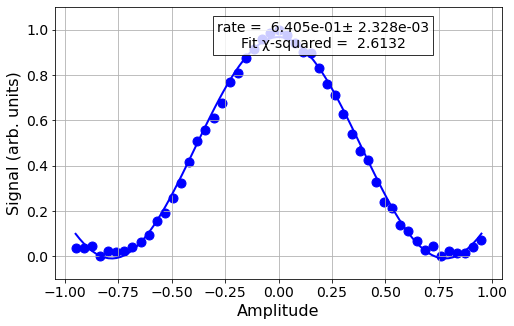

In [16]:
rabi = Rabi(qubit)
rabi.set_experiment_options(
    amplitudes=np.linspace(-0.95, 0.95, 51), 
    schedule=cals.get_schedule("xp", (0,), assign_params={"amp": Parameter("amp")}),
)
rabi_data = rabi.run(backend)

In [17]:
print(rabi_data)

---------------------------------------------------
Experiment: Rabi
Experiment ID: 1b39ae30-8515-4906-a575-78c1614af593
Status: DONE
Circuits: 51
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- amp: 0.48883660851515337 ± 0.002437200278038394
- freq: 0.6405190042625695 ± 0.002328449209796066
- phase: 0.0013763946049097733 ± 0.006990784170613186
- baseline: 0.47853905775238326 ± 0.0020801682434357384
- analysis_type: OscillationAnalysis
- reduced_chisq: 2.6132447113811534
- dof: 47
- xrange: [-0.95, 0.95]
- quality: computer_good
- success: True


In [18]:
Amplitude.update(cals, rabi_data, angles_schedules=[(np.pi, "amp", "xp")])

In [19]:
pd.DataFrame(cals.parameters_table(qubit_list=[qubit, ()], parameters="amp"))

,value,date_time,valid,exp_id,group,qubits,parameter,schedule
0,0.500000,2021-07-16 13:11:30.812427+0000,True,None,default,(),amp,xp
1,0.780617,2021-07-16 15:13:58.432000+0200,True,1b39ae30-8515-4906-a575-78c1614af593,default,"(0,)",amp,xp
2,0.500000,2021-07-16 13:11:30.812487+0000,True,None,default,(),amp,x90p


The table above shows that we have now updated the amplitude of our $\pi$-pulse from 0.5 to the value obtained in the most recent Rabi experiment. Importantly, since we linked the amplitudes of the `xp` and `x90p` schedules we will see that the amplitude of the `x90p` schedule has also been updated as cen be seen when requesting schedules form the `Calibrations` instance.

In [20]:
cals.get_schedule("x90p", 0)

ScheduleBlock(Play(Drag(duration=320, amp=(0.39030848+0j), sigma=80, beta=0.5), DriveChannel(0)), name="x90p", transform=AlignLeft())

In [21]:
cals.get_schedule("xp", 0)

ScheduleBlock(Play(Drag(duration=320, amp=(0.78061696+0j), sigma=80, beta=0.5), DriveChannel(0)), name="xp", transform=AlignLeft())

## 3. Saving and loading calibrations

The values of the calibrated parameters can be saved to a `.csv` file and reloaded at a later point in time.  

In [22]:
cals.save(file_type="csv", overwrite=True, file_prefix="Armonk")

/home/daniel/Documents/IBM/qiskit/qiskit-experiments/qiskit_experiments/calibration/management/calibrations.py:937: UserWarning: Schedules are only saved in text format. They cannot be re-loaded.
  warnings.warn("Schedules are only saved in text format. They cannot be re-loaded.")


After saving the values of the parameters you may restart your kernel. If you do so, you will only need to run the following cell to recover the state of your calibrations. Since the schedules are currently not stored we need to call our `setup_cals` function to populate an instance of `Calibrations` with the template schedules. By contrast, the value of the parameters will be recovered from the file.

In [23]:
cals = setup_cals(backend)
cals.load_parameter_values(file_name="Armonkparameter_values.csv")

In [24]:
pd.DataFrame(cals.parameters_table(qubit_list=[qubit, ()], parameters="amp"))

,value,date_time,valid,exp_id,group,qubits,parameter,schedule
0,0.500000,2021-07-16 13:11:30.812427+0000,True,,default,(),amp,xp
1,0.780617,2021-07-16 15:13:58.432000+0200,True,1b39ae30-8515-4906-a575-78c1614af593,default,"(0,)",amp,xp
2,0.500000,2021-07-16 13:11:30.812487+0000,True,,default,(),amp,x90p


## 4. Calibrating the value of the DRAG coefficient

A Derivative Removal by Adiabatic Gate (DRAG) pulse is designed to minimize leakage
to a neighbouring transition. It is a standard pulse with an additional derivative
component. It is designed to reduce the frequency spectrum of a normal pulse near
the $|1\rangle$ - $|2\rangle$ transition, reducing the chance of leakage
to the $|2\rangle$ state. The optimal value of the DRAG parameter is chosen to
minimize both leakage and phase errors resulting from the AC Stark shift.

\begin{align}
    f(t) = \Omega_x(t) + j \beta \frac{\rm d}{{\rm d }t} \Omega_x(t)
\end{align}

Here, $\Omega_x$ is the envelop of the in-phase component of the pulse and
$\beta$ is the strength of the quadrature which we refer to as the DRAG
parameter and seek to calibrate in this experiment. The DRAG calibration will run
several series of circuits. In a given circuit a Rp(β) - Rm(β) block is repeated
$N$ times. Here, Rp is a rotation with a positive angle and Rm is the same rotation
with a native angle. As example the circuit of a single repetition, i.e. $N$, is
shown below.

In [25]:
from qiskit_experiments.calibration.drag import DragCal
from qiskit_experiments.calibration.management.update_library import Drag

In [26]:
cal_drag = DragCal(qubit)

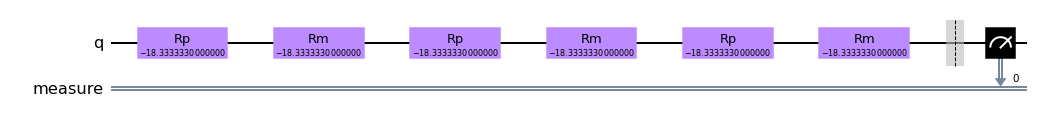

In [27]:
cal_drag.set_experiment_options(
    rp=cals.get_schedule("xp", 0, assign_params={"β": Parameter("β")}),
    betas=np.linspace(-20, 20, 25),
    reps=[3, 5, 7]
)

cal_drag.circuits(backend)[1].draw(output='mpl')

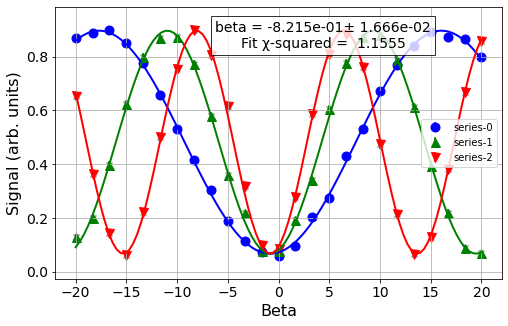

In [28]:
drag_data = cal_drag.run(backend)

In [29]:
Drag.update(cals, drag_data, parameter="β", schedule="xp")

In [30]:
pd.DataFrame(cals.parameters_table(qubit_list=[qubit, ()], parameters="β"))

,value,date_time,valid,exp_id,group,qubits,parameter,schedule
0,0.500000,2021-07-16 13:11:30.812459+0000,True,,default,(),β,x90p
1,0.500000,2021-07-16 13:11:30.812390+0000,True,,default,(),β,xp
2,-0.821526,2021-07-16 15:15:34.031000+0200,True,4059a3f6-0863-46b8-a4ca-94cf096c7aa5,default,"(0,)",β,xp


## 5. Fine amplitude calibration

The `FineAmplitude` calibration experiment repeats $N$ times a gate with a pulse
to amplify the under-/over-rotations in the gate to determine the optimal amplitude.
The circuits that are run have a custom gate with the pulse schedule attached to it
through the calibrations.

In [31]:
from qiskit_experiments.calibration.fine_amplitude import FineXAmplitude
from qiskit_experiments.calibration.management.update_library import Amplitude

In [32]:
amp_x_cal = FineXAmplitude(qubit)
amp_x_cal.set_experiment_options(schedule=cals.get_schedule("xp", 0))

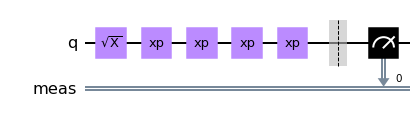

In [33]:
amp_x_cal.circuits(backend)[5].draw(output="mpl")

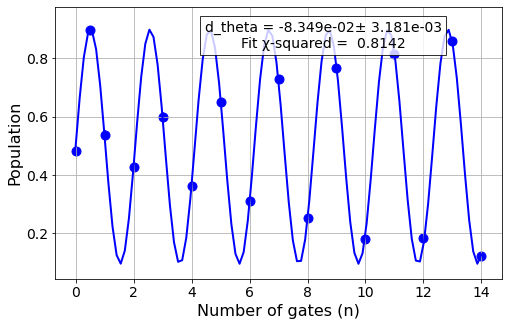

In [34]:
data_fine = amp_x_cal.run(backend)

In [35]:
result = data_fine.analysis_result(-1)

In [36]:
dtheta = result["popt"][1]
target_angle = np.pi
scale = target_angle / (target_angle + dtheta)
pulse_amp = cals.get_parameter_value("amp", 0, "xp")
print(f"The ideal angle is {target_angle:.2f} rad. We measured a deviation of {dtheta:.3f} rad.")
print(f"Thus, scale the {pulse_amp:.4f} pulse amplitude by {scale:.3f} to obtain {pulse_amp*scale:.5f}.")

The ideal angle is 3.14 rad. We measured a deviation of -0.083 rad.
Thus, scale the 0.7806 pulse amplitude by 1.027 to obtain 0.80193.


In [37]:
Amplitude.update(cals, data_fine, angles_schedules=[(target_angle, "amp", "xp")])

In [38]:
pd.DataFrame(cals.parameters_table(qubit_list=[qubit, ()], parameters="amp"))

,value,date_time,valid,exp_id,group,qubits,parameter,schedule
0,0.500000,2021-07-16 13:11:30.812427+0000,True,,default,(),amp,xp
1,0.780617,2021-07-16 15:13:58.432000+0200,True,1b39ae30-8515-4906-a575-78c1614af593,default,"(0,)",amp,xp
2,0.801930,2021-07-16 15:16:06.442000+0200,True,e666fe7c-2982-4e67-b5a6-17cdb4cf07db,default,"(0,)",amp,xp
3,0.500000,2021-07-16 13:11:30.812487+0000,True,,default,(),amp,x90p


To check that we have managed to reduce the error in the rotation angle we will run the fine amplitude calibration experiment once again.

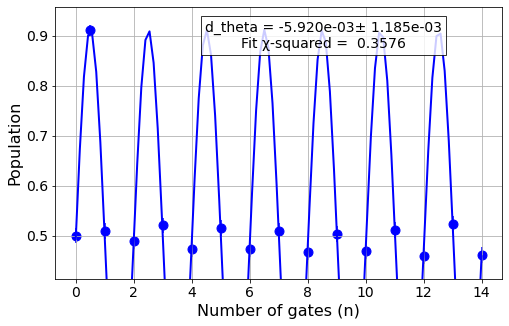

In [39]:
amp_x_cal.set_experiment_options(schedule=cals.get_schedule("xp", 0))
data_fine2 = amp_x_cal.run(backend)

As can be seen from the data above and the analysis result below we have managed to reduce the error in the rotation angle ${\rm d}\theta$.

In [40]:
data_fine2.analysis_result(-1)

{'analysis_type': 'FineAmplitudeAnalysis',
 'popt': array([-0.83728222, -0.00592034,  0.49346967]),
 'popt_keys': ['amp', 'd_theta', 'baseline'],
 'popt_err': array([0.01945054, 0.00118544, 0.00403677]),
 'pcov': array([[ 3.78323418e-04, -3.22962018e-06,  3.25900820e-05],
        [-3.22962018e-06,  1.40527151e-06, -5.06936441e-07],
        [ 3.25900820e-05, -5.06936441e-07,  1.62955153e-05]]),
 'reduced_chisq': 0.357634237758654,
 'dof': 13,
 'xrange': [0.0, 14.0],
 'quality': 'computer_good',
 'success': True}

### Fine amplitude calibration of the $\pi/2$ rotation

We now wish to calibrate the amplitude of the $\pi/2$ rotation independently from the amplitude of the $\pi$-rotation. To do this we need to break the link between the parameters by replacing the template schedule.

In [41]:
x90p_template = cals.get_template("x90p")
dur = x90p_template.blocks[0].pulse.duration
sigma = x90p_template.blocks[0].pulse.sigma
chan = x90p_template.blocks[0].channel
beta = x90p_template.blocks[0].pulse.beta

with pulse.build(name="x90p") as x90p_sched:
    pulse.play(pulse.Drag(duration=dur, amp=Parameter("amp"), sigma=sigma, beta=beta), chan)
    
with pulse.build(name="xp") as xp_sched:
    pulse.play(pulse.Drag(duration=dur, amp=Parameter("amp"), sigma=sigma, beta=beta), chan)
    
cals.add_schedule(x90p_sched)
cals.add_schedule(xp_sched)
amp_val = cals.get_parameter_value("amp", 0, "xp")/2
cals.add_parameter_value(amp_val, "amp", 0, "x90p")

In [42]:
from qiskit_experiments.calibration.fine_amplitude import FineSXAmplitude

In [43]:
amp_sx_cal = FineSXAmplitude(qubit)
amp_sx_cal.set_experiment_options(schedule=cals.get_schedule("x90p", 0))

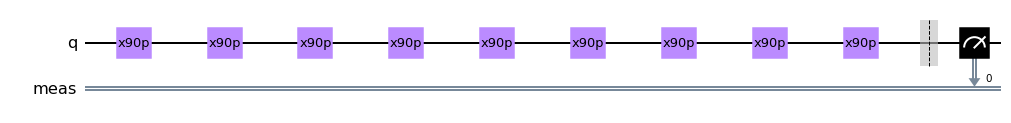

In [44]:
amp_sx_cal.circuits(backend)[5].draw(output="mpl")

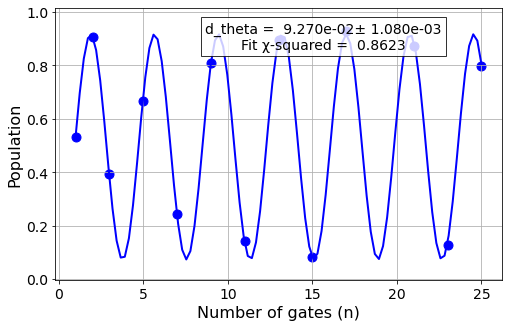

In [45]:
data_fine_sx = amp_sx_cal.run(backend)

In [46]:
Amplitude.update(cals, data_fine_sx, angles_schedules=[(np.pi/2, "amp", "x90p")])

In [47]:
pd.DataFrame(cals.parameters_table(qubit_list=[qubit, ()], parameters="amp"))

,value,date_time,valid,exp_id,group,qubits,parameter,schedule
0,0.500000,2021-07-16 13:11:30.812427+0000,True,,default,(),amp,xp
1,0.780617,2021-07-16 15:13:58.432000+0200,True,1b39ae30-8515-4906-a575-78c1614af593,default,"(0,)",amp,xp
2,0.801930,2021-07-16 15:16:06.442000+0200,True,e666fe7c-2982-4e67-b5a6-17cdb4cf07db,default,"(0,)",amp,xp
3,0.400965,2021-07-16 13:16:55.034459+0000,True,None,default,"(0,)",amp,x90p
4,0.378622,2021-07-16 15:17:21.900000+0200,True,3db3ce21-e7ed-4f6e-bc49-41d7ef71b9e6,default,"(0,)",amp,x90p
5,0.500000,2021-07-16 13:11:30.812487+0000,True,,default,(),amp,x90p


In [48]:
cals.get_schedule("x90p", 0)

ScheduleBlock(Play(Drag(duration=320, amp=(0.378621566646741+0j), sigma=80, beta=-0.82152558180058), DriveChannel(0)), name="x90p", transform=AlignLeft())

In [49]:
cals.get_schedule("xp", 0)

ScheduleBlock(Play(Drag(duration=320, amp=(0.80192971521237+0j), sigma=80, beta=-0.82152558180058), DriveChannel(0)), name="xp", transform=AlignLeft())

Which shows us that the amplitude of the $\pi$-rotation and the $\pi/2$-rotation are no longer related by a factor of 2.